In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
GSHEET_KEY="1YGGro_pvgAgFIB1yx42VShYsTe2zqBimzwubUeofoXY"
sheet_name = "Sheet1"
url=f"https://docs.google.com/spreadsheet/ccc?key={GSHEET_KEY}&output=xlsx"
df = pd.read_excel(url,sheet_name=sheet_name)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   project           105 non-null    object 
 1   issue_number      105 non-null    int64  
 2   issue_type        105 non-null    object 
 3   text              104 non-null    object 
 4   cleaned_text      104 non-null    object 
 5   human_annotation  105 non-null    object 
 6   chatgpt_text      105 non-null    object 
 7   chatgpt_clean     0 non-null      float64
 8   bert_text         105 non-null    object 
 9   roberta_text      105 non-null    object 
 10  classification    105 non-null    object 
 11  indicator         105 non-null    object 
dtypes: float64(1), int64(1), object(10)
memory usage: 10.0+ KB


In [ ]:
df.head()

,project,issue_number,issue_type,text,cleaned_text,human_annotation,chatgpt_text,chatgpt_clean,bert_text,roberta_text,classification,indicator
0,camel,10009,comment_0,If you use then it works,use work,neutral,positive,NaN,neutral,positive,non_debt,-
1,camel,10009,description,If you use spring and then refer to an endpoin...,use spring refer endpoint route get spring error,neutral,neutral,NaN,neutral,neutral,non_debt,-
2,camel,10009,summary,Using <to> with id and ref fails,using id ref fails,negative,negative,NaN,negative,negative,non_debt,-
3,camel,10022,comment_0,There is a basic health indicator now.,basic health indicator,neutral,positive,NaN,neutral,neutral,non_debt,-
4,camel,10022,comment_1,We need the health check API in camel-core for...,need health check api camelcore fine grained s...,neutral,negative,NaN,neutral,neutral,non_debt,-


<Figure size 1200x600 with 0 Axes>

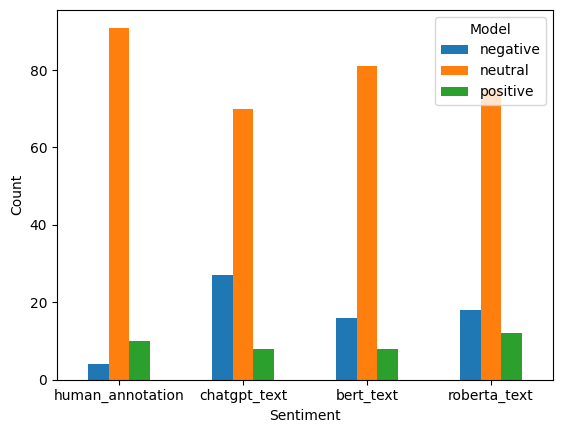

In [ ]:
sentiment_columns = ['human_annotation', 'chatgpt_text',
                     'bert_text', 'roberta_text']

sentiment_counts = df[sentiment_columns].apply(pd.Series.value_counts)

plt.figure(figsize=(12, 6))
sentiment_counts.T.plot(kind='bar')
# plt.title('Sentiment Analysis Comparison')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Model', loc='upper right')
plt.xticks(rotation=0)
plt.show()

In [ ]:
df['chatgpt_agreement'] = df['human_annotation'] == df['chatgpt_text']
df['bert_agreement'] = df['human_annotation'] == df['bert_text']
df['roberta_agreement'] = df['human_annotation'] == df['roberta_text']

agreement_counts = pd.DataFrame({
    'Model': ['ChatGPT', 'BERT', 'RoBERTa'],
    'Agreement': [
        df['chatgpt_agreement'].sum(),
        df['bert_agreement'].sum(),
        df['roberta_agreement'].sum()
    ],
    'Disagreement': [
        (~df['chatgpt_agreement']).sum(),
        (~df['bert_agreement']).sum(),
        (~df['roberta_agreement']).sum()
    ]
})

agreement_counts

,Model,Agreement,Disagreement
0,ChatGPT,64,41
1,BERT,85,20
2,RoBERTa,78,27


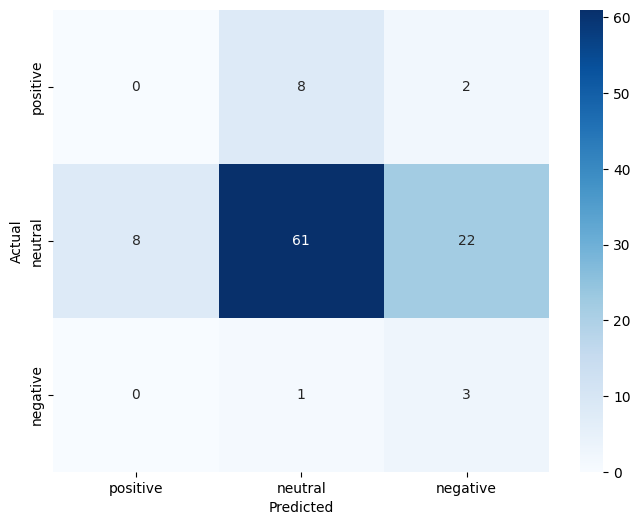

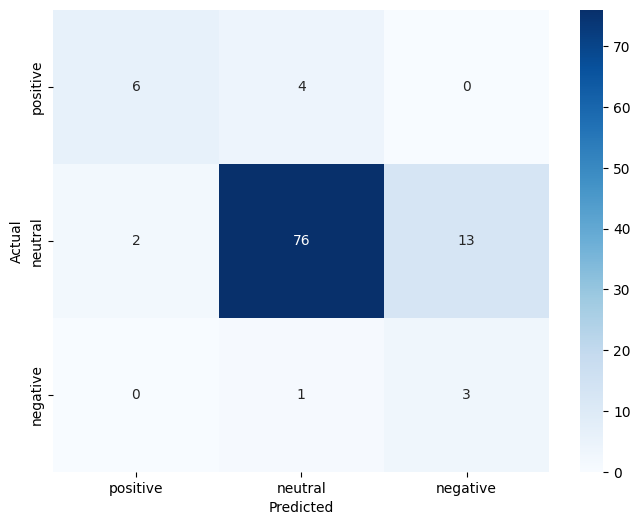

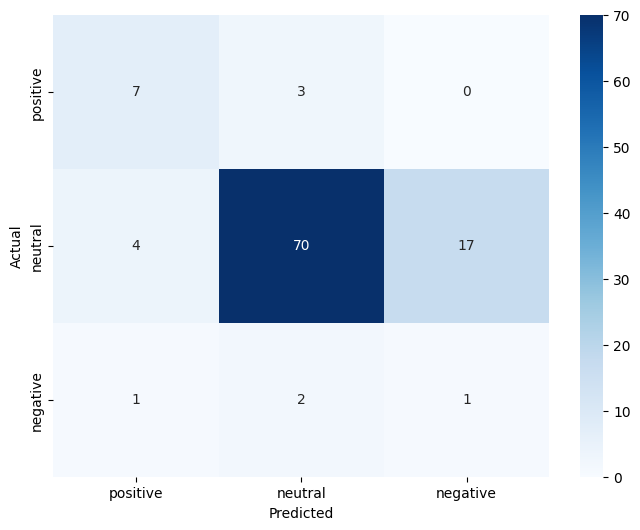

In [ ]:
def plot_confusion_matrix(model_column, model_name):
    cm = confusion_matrix(df['human_annotation'], df[model_column], labels=['positive', 'neutral', 'negative'])
    cm_df = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    # plt.title(f'Confusion Matrix: Human vs {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

# Plot and save confusion matrices for each model
plot_confusion_matrix('chatgpt_text', 'ChatGPT')
plot_confusion_matrix('bert_text', 'BERT')
plot_confusion_matrix('roberta_text', 'RoBERTa')

In [ ]:
def print_disagreements(model_column, model_name):
    disagreements = df[df['human_annotation'] != df[model_column]]
    print(f"\nDisagreements for {model_name}:")
    print(disagreements[['text', 'human_annotation', model_column]].head(10))  # Print first 10 examples

    disagreement_counts = disagreements['human_annotation'].value_counts()
    print(f"\nDisagreement counts for {model_name}:")
    print(disagreement_counts)

    return disagreements

chatgpt_disagreements = print_disagreements('chatgpt_text', 'ChatGPT')
bert_disagreements = print_disagreements('bert_text', 'BERT')
roberta_disagreements = print_disagreements('roberta_text', 'RoBERTa')

all_disagreements = pd.concat([chatgpt_disagreements, bert_disagreements, roberta_disagreements])
highest_disagreement_label = all_disagreements['human_annotation'].value_counts().idxmax()


Disagreements for ChatGPT:
                                                 text human_annotation  \
0                            If you use then it works          neutral   
3              There is a basic health indicator now.          neutral   
4   We need the health check API in camel-core for...          neutral   
9                camel-avro - Cannot install in karaf         negative   
13  RoutingSlip has a cache of error handlers impl...          neutral   
15  This template is ONLY for reporting privacy is...          neutral   
26  I am, but I tested it with them all disabled a...          neutral   
27  Marking the Bug as invalid... If you still enc...          neutral   
29  : 1. View the above page. Visible italic text....          neutral   
31  master, but also prod 1. Open a change in Gerr...          neutral   

   chatgpt_text  
0      positive  
3      positive  
4      negative  
9       neutral  
13     positive  
15     negative  
26     negative  
27     negati